In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
from skimage.filters import gaussian
from scipy.ndimage import zoom, center_of_mass, shift, affine_transform
import cv2

import ipywidgets
from pathlib import Path
from tqdm import tqdm
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
#"ipyvtklink", "panel", "ipygany", "static", "pythreejs", "client", "server", "trame", "none"
pv.set_jupyter_backend("panel")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
PIPELINE_ROOT = Path('./').absolute().parents[1]
PIPELINE_ROOT = PIPELINE_ROOT.as_posix()
sys.path.append(PIPELINE_ROOT)
print(PIPELINE_ROOT)

data_path = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data'
from library.atlas.atlas_utilities import register_volume, adjust_volume, affine_transform_volume, apply_affine_transform

/home/eddyod/programming/pipeline/src


In [9]:
def visualize_slices(volume, title="Slice View"):
    """Visualize the middle slices of a 3D volume."""
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    mid_slices = [s // 2 for s in volume.shape]
    
    axes[0].imshow(volume[mid_slices[0], :, :], cmap='gray')
    axes[0].set_title("Axial Slice")
    axes[1].imshow(volume[:, mid_slices[1], :], cmap='gray')
    axes[1].set_title("Coronal Slice")
    axes[2].imshow(volume[:, :, mid_slices[2]], cmap='gray')
    axes[2].set_title("Sagittal Slice")
    
    for ax in axes:
        ax.axis("on")
    plt.suptitle(title)
    plt.show()


def get_evenly_spaced_vertices(mask, num_points):
    """
    Given a binary mask, extract the outer contour and return evenly spaced vertices along the edge.

    Parameters:
    - mask: 2D numpy array (binary mask)
    - num_points: Number of evenly spaced points to return

    Returns:
    - List of (x, y) coordinates of vertices
    """
    # Ensure mask is uint8
    mask = mask.astype(np.uint8)

    # Find contours (external only)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return []

    # Choose the largest contour (in case there are multiple)
    contour = max(contours, key=cv2.contourArea).squeeze()

    # Calculate arc length (perimeter)
    arc_length = cv2.arcLength(contour, True)
    print(arc_length)

    # Calculate the cumulative arc lengths
    distances = [0]
    for i in range(1, len(contour)):
        d = np.linalg.norm(contour[i] - contour[i - 1])
        distances.append(distances[-1] + d)
    distances = np.array(distances)

    # Sample points at regular intervals
    desired_distances = np.linspace(0, distances[-1], num_points, endpoint=False)
    vertices = []
    j = 0
    for d in desired_distances:
        while j < len(distances) - 1 and distances[j+1] < d:
            j += 1
        # Linear interpolation between points j and j+1
        t = (d - distances[j]) / (distances[j+1] - distances[j])
        pt = (1 - t) * contour[j] + t * contour[j + 1]
        vertices.append(tuple(pt.astype(int)))

    return vertices

In [16]:
structure = 'SC'
animal = 'AtlasV8'
structure_path = os.path.join(data_path, animal, 'structure', f'{structure}.npy')
arr = np.load(structure_path)
print(arr.shape, arr.dtype)

(211, 179, 362) float32


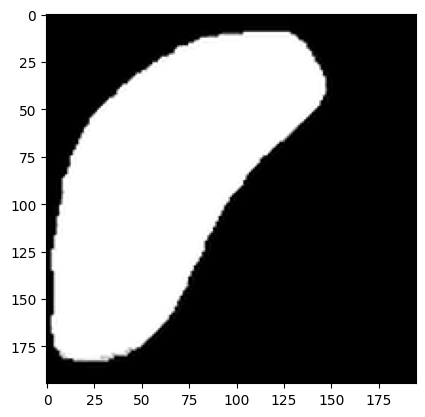

In [15]:
z = arr.shape[2] // 2
volume = arr.copy()
#volume = adjust_volume(volume, 255)
slice = volume[:,:,z].astype(np.uint8)
plt.imshow(slice, cmap='gray')

510.6589421033859


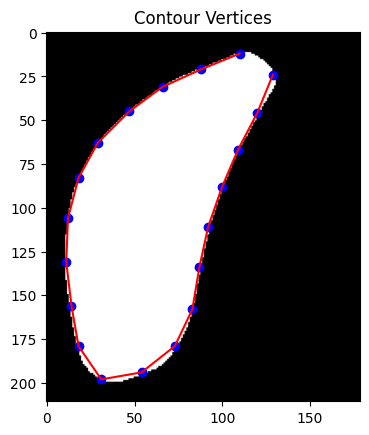

In [10]:
#n, nl, vertices = get_outer_edge_vertices(slice)
vertices = get_evenly_spaced_vertices(slice, 20)
# Visualize result
plt.imshow(slice, cmap='gray')
x, y = zip(*vertices)
plt.plot(x, y, 'r-')
plt.scatter(x, y, c='blue')
plt.title("Contour Vertices")
plt.show()

In [ ]:
slice = volume[:,:,z].astype(np.uint8)
#get_outer_edge_vertices(slice)
for z in range(volume.shape[2]):
    print(z)

In [ ]:
data = pv.wrap(volume)
data.plot(volume=True) # Volume render

In [ ]:
#transformed_volume = affine_transform_volume(volume, transformation_matrix)
# Visualize original and transformed volumes
visualize_slices(volume, title="Original Volume")
visualize_slices(transformed_volume, title="Transformed Volume")